In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
material_df = pd.read_excel('Material Master Data.xlsx')
sales_df = pd.read_excel('Sales Order.xlsx')
stock_df = pd.read_excel('Stock level.xlsx')

## Exploratory Data Analysis 

In [4]:
material_df.head()

,SKU ID,Product Name,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price
0,1009AA,Chainring Elite,Kg,30,48,28.76
1,1077CA,Tire Thrust,Kg,45,70,22.98
2,1083AA,Brake Caliper Pro,Kg,45,68,29.02
3,1116CA,Saddle Supreme,Kg,90,140,32.80
4,1126CA,Handlebar Fusion,Kg,45,62,32.80


In [5]:
stock_df.head()

,SKU ID,Current Stock Quantity
0,1009AA,7210.00
1,1077CA,46516.00
2,1083AA,48210.00
3,1116CA,33398.00
4,1126CA,39270.00


In [6]:
sales_df.head()

,Order Date,SKU ID,Order Quantity,Unit Price
0,2023-11-19,3084CA,1.00,2769.81
1,2023-06-30,2621AA,20.00,61.78
2,2024-04-19,1193BA,147.00,815.00
3,2024-05-21,1971AA,10.00,321.95
4,2023-03-31,3177CA,56.25,69.46


### Summary order statistics

In [16]:
print(sales_df.describe())

       Order Quantity  Unit Price  Total Sales
count        33919.00    33919.00     33919.00
mean           432.79     4659.34     15148.05
std           2382.90    20140.35     59448.17
min              0.00        0.10         0.03
25%              2.00       30.00       215.03
50%              6.00       73.00      1474.56
75%             36.29      740.82      8550.82
max         111770.00   175000.00   2569984.49


### Time Series Analysis
Analyze the data over time to identify trends and seasonality 

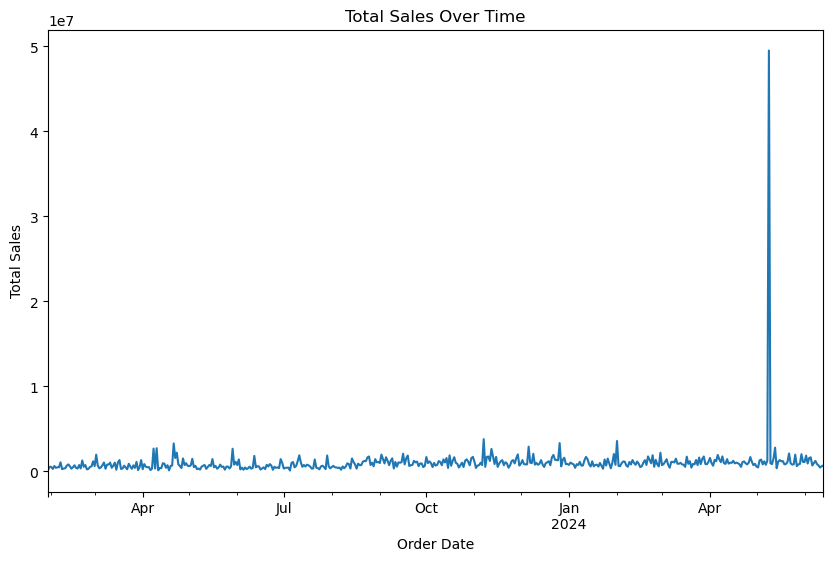

In [13]:
# Aggregate sales data by date
sales_df['Total Sales'] = sales_df['Order Quantity'] * sales_df['Unit Price']
time_series = sales_df.groupby('Order Date')['Total Sales'].sum()

# Plotting the time series
plt.figure(figsize=(10, 6))
time_series.plot()
plt.title('Total Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.show()

### Sales Distribution
Analyze the distribution of sales quantities and unit prices.

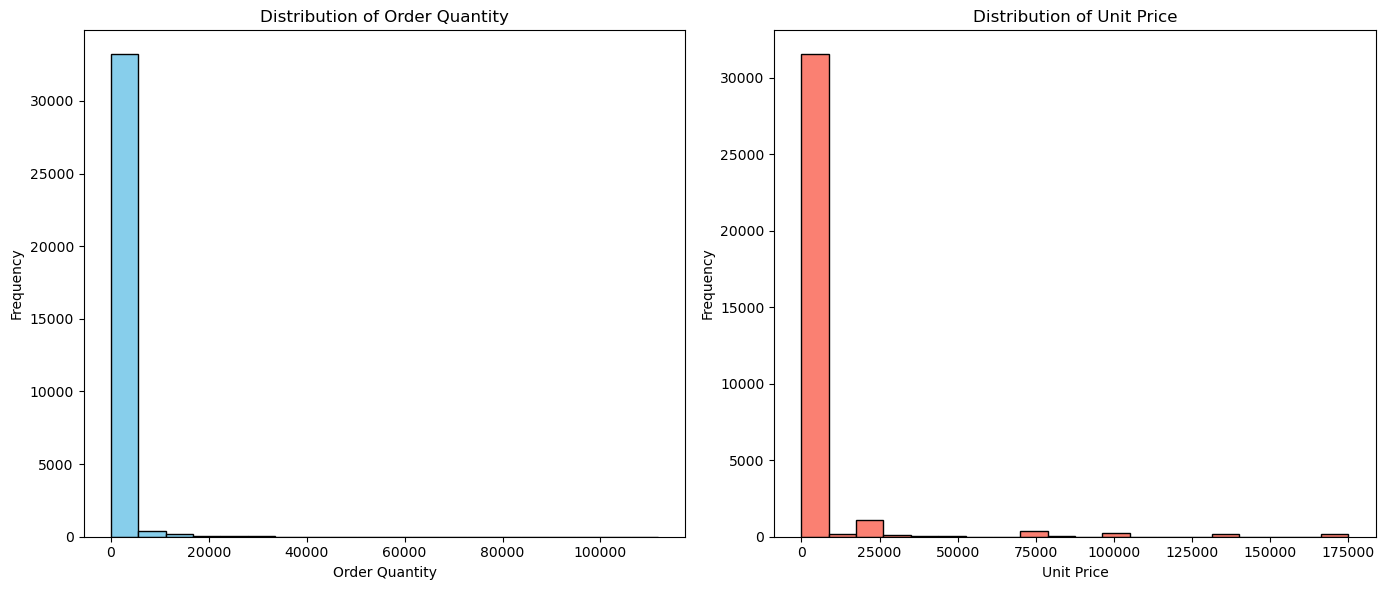

In [15]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Distribution of Order Quantity
axs[0].hist(sales_df['Order Quantity'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Order Quantity')
axs[0].set_xlabel('Order Quantity')
axs[0].set_ylabel('Frequency')

# Plot Distribution of Unit Price
axs[1].hist(sales_df['Unit Price'], bins=20, color='salmon', edgecolor='black')
axs[1].set_title('Distribution of Unit Price')
axs[1].set_xlabel('Unit Price')
axs[1].set_ylabel('Frequency')

# Show plot
plt.tight_layout()
plt.show()

In [257]:
#merge data
current_stock = material_df.merge(stock_df, how='left', on='SKU ID')
current_stock.head()

,SKU ID,Product Name,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price,Current Stock Quantity
0,1009AA,Chainring Elite,Kg,30,48,28.76,7210.00
1,1077CA,Tire Thrust,Kg,45,70,22.98,46516.00
2,1083AA,Brake Caliper Pro,Kg,45,68,29.02,48210.00
3,1116CA,Saddle Supreme,Kg,90,140,32.80,33398.00
4,1126CA,Handlebar Fusion,Kg,45,62,32.80,39270.00


In [258]:
material_list = material_df[['SKU ID']]
material_list

,SKU ID
0,1009AA
1,1077CA
2,1083AA
3,1116CA
4,1126CA
...,...
298,3579CA
299,3590BA
300,3610AA
301,3616CA


## ABC Classification

In [259]:
# Filter the DataFrame to include only rows where 'Order Date' is within the last 365 days
filtered_sales = sales_df[sales_df['Order Date'] >= datetime.now() - timedelta(days=365)]
abc_df = filtered_sales.copy()
abc_df.loc[:,'Total Sales'] = abc_df['Order Quantity'] * abc_df['Unit Price']
abc_df = abc_df.groupby('SKU ID')['Total Sales'].sum().reset_index()
abc = material_list.merge(abc_df, how='left', on='SKU ID')
abc['Total Sales'].fillna(0, inplace=True)
abc['Revenue Share'] = abc['Total Sales']/sum(abc['Total Sales'])*100
abc['Cumulative Share'] = abc.sort_values('Revenue Share', ascending = False)['Revenue Share'].cumsum()
abc['ABC Rank'] = abc['Revenue Share'].rank(ascending=False).astype(int)
abc = abc.sort_values('Cumulative Share').reset_index(drop=True)
abc

,SKU ID,Total Sales,Revenue Share,Cumulative Share,ABC Rank
0,1244AA,33015007.55,7.45,7.45,1
1,1295CA,22518064.43,5.08,12.53,2
2,1281BA,18468365.53,4.17,16.70,3
3,1193BA,14577090.00,3.29,19.98,4
4,3205AA,14212822.33,3.21,23.19,5
...,...,...,...,...,...
298,3276AA,0.00,0.00,100.00,297
299,1491CA,0.00,0.00,100.00,297
300,3274CA,0.00,0.00,100.00,297
301,2982AA,0.00,0.00,100.00,297


In [260]:
# define function
def abc_classification(value):
    if value <= 70:
        result = 'A[High Value]'
    elif value <= 90:
        result = 'B[Medium Value]'
    else:
        result = 'C[Less Value]'
    return result

abc['ABC Classification'] = abc['Cumulative Share'].apply(abc_classification)

## XYZ Classification

In [261]:
filtered_sales

,Order Date,SKU ID,Order Quantity,Unit Price
0,2023-11-19,3084CA,1.00,2769.81
1,2023-06-30,2621AA,20.00,61.78
2,2024-04-19,1193BA,147.00,815.00
3,2024-05-21,1971AA,10.00,321.95
5,2023-07-04,1385CA,13.00,1781.55
...,...,...,...,...
33914,2024-05-09,1308BA,3.43,30.00
33915,2024-05-09,1296CA,6.91,30.00
33916,2024-05-09,1295CA,1.14,175000.00
33917,2024-05-09,1283CA,0.62,98333.33


In [262]:
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=1)
all_weeks = pd.date_range(start=start_date, end=end_date, freq='W')

weeks_df = pd.DataFrame({'Order Date': all_weeks})
weeks_df['Order Date'] = weeks_df['Order Date'].dt.date

In [263]:
xyz = weeks_df.merge(material_list, how='cross')
xyz_sales = filtered_sales.groupby(['SKU ID', pd.Grouper(key='Order Date', freq='W')])['Order Quantity'].sum().reset_index()
xyz_sales['Order Date'] = xyz_sales['Order Date'].dt.date
xyz = xyz.merge(xyz_sales, how='left', on=['Order Date', 'SKU ID']).fillna(0)
xyz

,Order Date,SKU ID,Order Quantity
0,2023-05-14,1009AA,3001.00
1,2023-05-14,1077CA,0.00
2,2023-05-14,1083AA,1265.00
3,2023-05-14,1116CA,10580.00
4,2023-05-14,1126CA,500.00
...,...,...,...
15751,2024-05-05,3579CA,4.00
15752,2024-05-05,3590BA,0.00
15753,2024-05-05,3610AA,0.00
15754,2024-05-05,3616CA,0.00


In [264]:
xyz = xyz.groupby('SKU ID')['Order Quantity'].agg(['mean', 'std']).reset_index()
xyz.columns = ['SKU ID', 'Avg Weekly Demand', 'Std Weekly Demand']
xyz['Coefficient Variation'] = xyz['Std Weekly Demand']/xyz['Avg Weekly Demand']
xyz['Coefficient Variation'].fillna(1000, inplace=True)
xyz['CV Rank'] = xyz['Coefficient Variation'].rank(method='dense', ascending=True).astype(int)
xyz

,SKU ID,Avg Weekly Demand,Std Weekly Demand,Coefficient Variation,CV Rank
0,1009AA,1323.73,1592.28,1.20,116
1,1077CA,6799.29,7039.89,1.04,80
2,1083AA,5516.94,5325.46,0.97,48
3,1116CA,6052.35,8448.31,1.40,138
4,1126CA,6317.08,8571.54,1.36,134
...,...,...,...,...,...
298,3579CA,3.60,16.64,4.63,261
299,3590BA,24.87,38.84,1.56,159
300,3610AA,7.56,19.39,2.56,213
301,3616CA,10.85,39.62,3.65,242


In [265]:
# Define function for XYZ classification
def xyz_classification(value, count):
    if value <= 0.2 * count:
        result = 'X[Constant Demand]'
    elif value <= 0.5 * count:
        result = 'Y[Stable Demand]'
    else:
        result = 'Z[Erratic Demand]'
    return result

# Get count of CV Rank
count = xyz['CV Rank'].max()

# Apply function to create new column
xyz['XYZ Classification'] = xyz['CV Rank'].apply(lambda x: xyz_classification(x, count))

In [266]:
xyz.sort_values('CV Rank', ascending = False)

,SKU ID,Avg Weekly Demand,Std Weekly Demand,Coefficient Variation,CV Rank,XYZ Classification
270,3296AA,0.00,0.00,1000.00,290,Z[Erratic Demand]
52,1491CA,0.00,0.00,1000.00,290,Z[Erratic Demand]
272,3300CA,0.00,0.00,1000.00,290,Z[Erratic Demand]
271,3299CA,0.00,0.00,1000.00,290,Z[Erratic Demand]
269,3291CA,0.00,0.00,1000.00,290,Z[Erratic Demand]
...,...,...,...,...,...,...
258,3178CA,2.95,2.31,0.78,5,X[Constant Demand]
259,3180BA,22.17,17.34,0.78,4,X[Constant Demand]
47,1479CA,22.10,17.02,0.77,3,X[Constant Demand]
263,3249CA,20.76,15.96,0.77,2,X[Constant Demand]


## Inventory turnover rate

In [267]:
current_stock['Value in Stock'] = current_stock['Unit Price']*current_stock['Current Stock Quantity']

In [268]:
df_all = current_stock.merge(abc, how='left', on='SKU ID').merge(xyz, how='left', on='SKU ID')

In [269]:
df_all['Inventory Turnover Rate'] = df_all['Total Sales']/ df_all['Value in Stock']

## Reorder Point

Reorder Point = Avg weekly demand + Safety Stock + lead time sales

In [270]:
#calculate safety stock
import scipy.stats as stats
def calculate_safety_stock(sd, z_score):
    return z_score * sd

# Calculate the Z-score based on the desired service level
service_level = 0.95
z_score = stats.norm.ppf(service_level)

df_all['Safety Stock'] = df_all['Std Weekly Demand'].apply(lambda x: calculate_safety_stock(x, z_score)).astype(int)

In [271]:
df_all['Reorder Point'] = (df_all['Safety Stock'] + df_all['Avg Weekly Demand']*df_all['Average Lead Time (days)']).astype(int)

In [272]:
df_all['Order Quanatity'] = df_all['Reorder Point'] - df_all['Current Stock Quantity'].astype(int)

## Export Data

In [273]:
df_all.to_excel('inventory_status.xlsx', index=False)